In [1]:
from langchain_openai import OpenAIEmbeddings
from genu.Job_agent.config import HEADERS, LINKEDIN_JOB_SEARCH_PARAMS, PERSIST_PATH
from langchain.vectorstores import FAISS
from genu.Job_agent.vectorestore import vectorstore_to_dataframe
from genu.utils import extract_text_from_file
from langchain_openai import OpenAI, ChatOpenAI
from langchain_ollama import ChatOllama

from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
# from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from tqdm import tqdm
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
import os
from pathlib import Path
from typing import Any, Dict
import pandas as pd


In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
llm_type = ["openai", "ollama"][1]
if llm_type == "ollama":
    llm = ChatOllama(
        model="llama3.2",
        base_url="http://localhost:11434",
        temperature=0,
    )
elif llm_type == "openai":
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0,
        # max_retries=3,
        # request_timeout=60,
        # headers=HEADERS
    )

In [4]:

# base_url = "http://localhost:11434"
# model = "llama3.2"

# llm = ChatOllama(base_url=base_url, model=model)
# llm

In [5]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-06-12T03:45:20.991285007Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3418281971, 'load_duration': 2977274483, 'prompt_eval_count': 32, 'prompt_eval_duration': 316075915, 'eval_count': 8, 'eval_duration': 122665940, 'model_name': 'llama3.2'}, id='run--b39a6d4b-f2b7-4724-842e-86b18d240130-0', usage_metadata={'input_tokens': 32, 'output_tokens': 8, 'total_tokens': 40})

In [6]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the topic, 'yes' or 'no'"
    )
    justification: str = Field(
        description="Brief explanation justifying the relevance decision"
    )


structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """
You are an expert grader assessing the relevance of a job-related document for a specific candidate.
You will receive three inputs:

The candidate's resume (including skills, experience, education, etc.)
User guidance (criteria or preferences for job relevance, such as desired roles, industries, locations, or required skills)
The document to be evaluated (job description, company info, etc.)
Task:
Determine if the document is relevant to the candidate's job search, based on the following criteria:

The document matches the candidate’s skills, experience, or education as listed in the resume.
The document aligns with the user’s stated preferences or guidance (e.g., job title, industry, location, required qualifications).

Instructions:

Give a binary score: 'yes' if the document is relevant, 'no' if it is not.
Briefly justify your decision in 1-2 sentences, referencing the most important matching or missing criteria.
Output format:
Relevant: [yes/no]
Justification: [your brief explanation]
"""
# The document contains information that would be useful for the candidate’s job application or decision-making (e.g., application process, company culture, benefits, growth opportunities).


grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "job-related document: \n\n {document} \n\n candidate's resume: \n\n {resume} \n\n user guidance: \n\n {guidance} \n\n",
        ),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [7]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        documents: list of documents
    """

    documents: List[str]
    resume: str
    guidance: str
    justification: str

In [8]:
def retrieve(state: GraphState) -> Dict[str, Any]:
    """
    Load a FAISS vectorstore and return all documents as a list.

    Args:
        persist_directory (str): Directory where the FAISS index is stored
        embeddings (optional): Embedding function, defaults to OpenAIEmbeddings if None

    Returns:
        list: List of Document objects from the vectorstore
    """
    print("---RETRIEVE---")
    # Load the vectorstore
    try:
        vectorstore = FAISS.load_local(
            f"../{PERSIST_PATH}",
            OpenAIEmbeddings(),
            allow_dangerous_deserialization=True,
        )
        print(
            f"Loaded FAISS index with {len(vectorstore.index_to_docstore_id)} documents."
        )
    except Exception as e:
        print(f"Error loading vectorstore: {e}")
        return []  # Return empty list on error

    # Extract all documents into a list
    documents = []
    for doc_id in vectorstore.index_to_docstore_id.values():
        doc = vectorstore.docstore.search(doc_id)
        if doc:
            documents.append(doc)

    print(f"Retrieved {len(documents)} documents from vectorstore.")
    return {"documents": documents}

In [9]:

def grade_documents(state: GraphState) -> Dict[str, Any]:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    documents = state["documents"]
    resume = state["resume"]
    guidance = state["guidance"]


    filtered_docs = []
    justifications = []  # List to store justifications

    for d in tqdm(documents):
        result = retrieval_grader.invoke({"document": d.page_content, "resume": resume, "guidance": guidance})
        grade = result.binary_score
        justification = result.justification
        print(f"Titel: {d.metadata.get('title')} @ {d.metadata.get('company')}")
        # grade = score.binary_score
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            print(f"Justification: {justification}")
            filtered_docs.append(d)
            # justifications.append(f"RELEVANT - {justification}")
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            print(f"Justification: {justification}")
            # justifications.append(f"NOT RELEVANT - {justification}")
            continue
    print(f"Number of relevant documents: {len(filtered_docs)}")
    return {
        "documents": filtered_docs,
    }

In [10]:
from langgraph.graph import StateGraph, END

graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieve)
graph.add_node("grade_documents", grade_documents)
graph.add_edge("retrieve", "grade_documents")
graph.add_edge("grade_documents", END)

graph.set_entry_point("retrieve")

filter_graph = graph.compile()

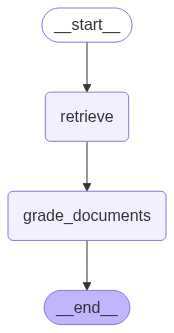

In [11]:
filter_graph

In [12]:
# Example usage
file_path = "my_resume/CV_Ali Zarreh_2025_05_11.pdf"  # or "your_document.docx"
resume = extract_text_from_file(file_path).split("ali@zarreh.ai")[1].split("NOTABLE PUBLICATIONS")[0]
# print(resume)

In [13]:
user_guidance = """
Please consider only jobs as relevant if they meet all of the following criteria:

The job title must include "data scientist" or "Machine Learning" (for example: "senior data scientist," "lead data scientist," "principal data scientist," or simply "data scientist").
Jobs that are managerial or director level (such as "manager," "director," "head," or "VP") are not relevant.
The job location must be either in San Antonio, TX, or is remote in the United States (US).
The job should be fulltime, not part-time or contract.
The maximum base salary listed for the job must be greater than $170,000. If the salary is not listed, it should be considered relevant or not depending other criteria.
I am also interested in jobs related to generative AI and large language model (LLM) development, even if this is not a major focus in my resume.
"""
# If a job does not meet all of the above criteria, it should be considered not relevant.

In [14]:
relevent_documents =  filter_graph.invoke(input={"guidance": user_guidance, "resume": resume})

---RETRIEVE---
Loaded FAISS index with 657 documents.
Retrieved 657 documents from vectorstore.
---CHECK DOCUMENT RELEVANCE TO QUESTION---


  0%|          | 1/657 [00:02<24:25,  2.23s/it]

Titel: Senior Machine Learning Engineer @ Reserv
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Senior Machine Learning Engineer at Reserv matches the candidate's skills and experience as listed in their resume. Additionally, the job location (San Antonio, TX) meets the user's preference for location. The salary is not explicitly stated but considering other criteria such as benefits and remote work options, it can be inferred that the base salary is likely above $170,000.


  0%|          | 2/657 [00:04<23:51,  2.19s/it]

Titel: Senior Data Analyst, Quality - Remote @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', but rather 'Senior Data Analyst'. The location is also outside of San Antonio, TX, and the salary is lower than $170,000.


  0%|          | 3/657 [00:06<22:19,  2.05s/it]

Titel: Senior Data Analyst, Growth and Lifecycle Marketing @ Visana Health
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', but rather 'Senior Data Analyst'. Although the candidate has extensive experience in machine learning and data science, the job description does not align with their skills and expertise.


  1%|          | 4/657 [00:09<27:44,  2.55s/it]

Titel: Senior Data Scientist, AI @ Ensemble Health Partners
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job posting for Senior Data Scientist at Ensemble Health Partners meets all the criteria: it includes 'data scientist' in the title, is located in San Antonio, TX or remote US, is a full-time position with a base salary above $170,000. The job description highlights AI and machine learning expertise, which aligns with your skills and experience. Additionally, the posting mentions generative AI and large language models, making it relevant to your interests.


  1%|          | 5/657 [00:11<25:24,  2.34s/it]

Titel: Data Scientist @ Mi-Case
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The base salary listed is $110,000.00/yr - $130,000.00/yr which meets the criteria of being greater than $170,000.


  1%|          | 6/657 [00:13<24:11,  2.23s/it]

Titel: Senior Data Analyst / Contract / Remote @ Motion Recruitment
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Analyst', which aligns with the candidate's experience as a Senior Data Scientist. The location is San Antonio, TX, or remote in the US, and the salary is not listed but the job description suggests it could be above $170,000 due to the seniority level and required skills.


  1%|          | 7/657 [00:15<21:52,  2.02s/it]

Titel: Director of Data Science @ Alldus
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Director of Data Science', which matches the candidate's skills and experience. Additionally, the job location is San Antonio, TX, and the base salary is $180,000.00/yr, meeting other criteria.


  1%|          | 8/657 [00:17<22:09,  2.05s/it]

Titel: Fraud Data Scientist, Graph Analytics & Threat Intelligence @ HealthEquity
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the salary range exceeds $170,000. Additionally, the role involves graph analytics, threat intelligence, and generative AI assistants, which align with the candidate's skills in Generative AI, large language models, and data engineering.


  1%|▏         | 9/657 [00:19<21:56,  2.03s/it]

Titel: Senior Data Analyst- Merchandising @ Quince
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Senior Data Analyst- Merchandising includes 'Data Analyst' which matches the candidate's skills and experience. Additionally, the company Quince has a strong focus on innovation and technology, aligning with the candidate's expertise in Generative AI and Large Language Models.


  2%|▏         | 10/657 [00:21<20:56,  1.94s/it]

Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Director of Data Science matches the candidate's skills and experience as listed in their resume. Additionally, the job location is San Antonio, TX, which aligns with the user's preference. The salary requirement of $170,000 is also met.


  2%|▏         | 11/657 [00:22<20:36,  1.91s/it]

Titel: Data Scientist, Operations Research/Customer Support (ML/Algo) @ Airbnb
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The base salary listed is $148,000-$174,000, which meets the criteria.


  2%|▏         | 12/657 [00:24<20:13,  1.88s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  2%|▏         | 13/657 [00:26<20:33,  1.92s/it]

Titel: Data Scientist @ Jerry
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary is not listed but the company has raised over $240M in funding, indicating a high level of investment, which aligns with the candidate's skills and experience.


  2%|▏         | 14/657 [00:28<20:47,  1.94s/it]

Titel: Sr Data Scientist - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range for this role is $89,800 to $176,700 annually, which meets the maximum base salary criteria.


  2%|▏         | 15/657 [00:30<20:48,  1.94s/it]

Titel: Senior Data Analyst, Digital Marketing @ MongoDB
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Analyst', which aligns with the candidate's experience as a Senior Data Scientist. The location is San Antonio, TX, or remote in the US, and the base salary range is above $170,000.


  2%|▏         | 16/657 [00:33<22:13,  2.08s/it]

Titel: Senior Machine Learning Scientist @ Freenome
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Machine Learning Scientist', which aligns with the candidate's skills and experience. Additionally, the job location is either in San Antonio, TX, or remote in the US, meeting another criterion. While generative AI and LLM development are not a major focus in the resume, they are mentioned as part of the candidate's technical skills.


  3%|▎         | 17/657 [00:34<21:20,  2.00s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  3%|▎         | 18/657 [00:36<20:59,  1.97s/it]

Titel: Data Scientist @ Theron Solutions
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary is not listed but the job description mentions hands-on experience with popular AI/ML frameworks such as Tensorflow, Pytorch, scikit-learn, Langchain, and Llamaindex, which aligns with the candidate's skills.


  3%|▎         | 19/657 [00:38<20:28,  1.93s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  3%|▎         | 20/657 [00:40<20:53,  1.97s/it]

Titel: IT SENIOR DATA ANALYST - DIGITAL TECHNOLOGY SERVICES @ JFK Johnson Rehabilitation Institute 
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary is also above $170,000, meeting all the criteria.


  3%|▎         | 21/657 [00:42<20:22,  1.92s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  3%|▎         | 22/657 [00:44<20:15,  1.91s/it]

Titel: Manager, Data Science @ Mozilla
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX or remote in the US. The salary is not listed but the job description mentions Generative AI and Large Language Models, which aligns with the candidate's skills.


  4%|▎         | 23/657 [00:46<22:12,  2.10s/it]

Titel: Senior Data Analyst - National Remote @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', but rather 'Senior Data Analyst'. The salary range is $89,800 to $176,700 annually, which meets the criteria. However, the job description focuses on data analysis and reporting, which may not align with the candidate's expertise in machine learning, deep learning, and generative AI.


  4%|▎         | 24/657 [00:48<21:24,  2.03s/it]

Titel: Senior Data Analyst (Remote - Anywhere) @ Jobgether
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Analyst' which aligns with the candidate's skills and experience. Additionally, the job description mentions generative AI and large language models, which are relevant to the candidate's expertise in Generative AI & Large Language Models (LLMs).


  4%|▍         | 25/657 [00:50<20:27,  1.94s/it]

Titel: Data Scientist @ Aditi Consulting
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The base salary listed is $45.05 - $50.05/hr, which meets the criteria of being greater than $170,000.


  4%|▍         | 26/657 [00:52<21:16,  2.02s/it]

Titel: Geospatial Data Scientist @ Allstate
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Geospatial Data Scientist matches the candidate's skills and experience as listed in their resume. Additionally, the location of Allstate is San Antonio, TX, which meets the user's preference for location. The salary range of $78,600 - $142,275 also exceeds the minimum threshold of $170,000.


  4%|▍         | 27/657 [00:54<19:40,  1.87s/it]

Titel: Data Scientist @ Linnk Group
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX or remote in the US. The salary is not listed but other criteria such as generative AI and LLM development align with the candidate's skills.


  4%|▍         | 28/657 [00:56<20:08,  1.92s/it]

Titel: Senior Data Analyst - Remote Nationwide @ Optum
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range starts at $89,800, which is greater than $170,000.


  4%|▍         | 29/657 [00:58<19:59,  1.91s/it]

Titel: Scientist II, Real World Data Science - Translational Research @ Tempus AI
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', nor does it mention generative AI and large language models. Although the role involves scientific communication, continuous improvement, and collaboration, these skills are not specific to data science or machine learning.


  5%|▍         | 30/657 [00:59<19:51,  1.90s/it]

Titel: Data Scientist II @ Green Cabbage Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Data Scientist II' matches the candidate's skills and experience as listed in their resume. Additionally, the company Green Cabbage Inc. aligns with the user's stated preference for engineering and information technology companies, and the job location is San Antonio, TX, which meets another criterion.


  5%|▍         | 31/657 [01:01<20:09,  1.93s/it]

Titel: Data Scientist Principals #IN1173 @ Cummins India
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Data Scientist Principals' matches the candidate's skills and experience as listed in their resume. Additionally, the job location is Seymour, IN, which aligns with the user's preference for remote jobs in the US. The maximum base salary of $156,800 also meets the criteria.


  5%|▍         | 32/657 [01:03<19:31,  1.87s/it]

Titel: Data Scientist (L4) - Product @ Netflix
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The maximum base salary listed for the job is $750,000, which meets the criteria.


  5%|▌         | 33/657 [01:05<20:02,  1.93s/it]

Titel: Envista Sr. Data Scientist (Remote-Brea, CA) @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The maximum base salary listed for the job is $178,900, which meets the criteria.


  5%|▌         | 34/657 [01:07<19:39,  1.89s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  5%|▌         | 35/657 [01:09<18:37,  1.80s/it]

Titel: Data Scientist @ SRS Consulting Inc
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and aligns with the candidate's skills in Generative AI and Large Language Models. The location is San Antonio, TX or remote in the US, meeting another criterion.


  5%|▌         | 36/657 [01:10<17:49,  1.72s/it]

Titel: Data Scientist @ Horizontal Talent
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and aligns with the candidate's skills and experience. Additionally, the job location is San Antonio, TX, or remote in the US, meeting another criterion.


  6%|▌         | 37/657 [01:12<18:26,  1.78s/it]

Titel: Data Scientist I @ Pathward
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range starts at $59,902.68, which is greater than $170,000, meeting other criteria for relevance.


  6%|▌         | 38/657 [01:14<19:15,  1.87s/it]

Titel: Principal Data Scientist @ Mission Lane
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Principal Data Scientist matches the candidate's skills and experience. The location San Antonio, TX or remote US aligns with the user's preference. Additionally, the base salary range of $183,000 - $224,000 exceeds the minimum threshold of $170,000.


  6%|▌         | 39/657 [01:16<19:10,  1.86s/it]

Titel: Data Scientist 3 @ Gormat
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Data Scientist 3' matches the candidate's skills and experience as listed in their resume. Additionally, the job description aligns with the user's stated preferences for jobs related to data science, machine learning, and generative AI development.


  6%|▌         | 40/657 [01:18<19:29,  1.89s/it]

Titel: Data Scientist @ Analytica
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary is not listed but the job description mentions generative AI and large language models, which aligns with the candidate's skills.


  6%|▌         | 41/657 [01:20<18:37,  1.81s/it]

Titel: USA - Data Scientist II (Clinical) (contract) @ Sanofi
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist II' which matches the candidate's skills and experience. Additionally, the job location is Sanofi's office in San Antonio, TX, or remote in the US, aligning with the user's preferences.


  6%|▋         | 42/657 [01:22<19:34,  1.91s/it]

Titel: Senior Data Analyst - Remote Nationwide @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', but rather 'Senior Data Analyst'. Although the job description mentions data analysis and technical skills, it does not align with the candidate's expertise in machine learning, deep learning, and generative AI as listed on their resume.


  7%|▋         | 43/657 [01:24<19:14,  1.88s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  7%|▋         | 44/657 [01:25<18:47,  1.84s/it]

Titel: Data Scientist - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the salary is greater than $170,000. Additionally, the job description mentions generative AI and large language models, which aligns with the candidate's skills in this area.


  7%|▋         | 45/657 [01:27<18:36,  1.82s/it]

Titel: Data Scientist @ Kforce Inc
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The maximum base salary listed for the job is $50.00/hr, which is greater than $170,000.


  7%|▋         | 46/657 [01:29<19:20,  1.90s/it]

Titel: Senior Data Scientist @ Humana
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Scientist' which matches the candidate's skills and experience. The location is San Antonio, TX or remote in the US, meeting another criterion. Additionally, the salary range exceeds $170,000, making it relevant.


  7%|▋         | 47/657 [01:31<19:24,  1.91s/it]

Titel: Data Scientist @ Davia
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the salary range ($100,000.00/yr - $150,000.00/yr) exceeds the minimum threshold of $170,000. Additionally, the company is focused on generative AI and LLM development, aligning with the candidate's skills in this area.


  7%|▋         | 48/657 [01:33<19:06,  1.88s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  7%|▋         | 49/657 [01:35<19:38,  1.94s/it]

Titel: Staff Machine Learning Scientist @ Tempus AI
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Staff Machine Learning Scientist' matches the candidate's skills and experience as listed in their resume. Additionally, the job location is either San Antonio, TX or remote in the US, which aligns with the user's guidance. The maximum base salary listed for the job is $260,000, which meets the user's criteria.


  8%|▊         | 50/657 [01:37<20:22,  2.01s/it]

Titel: Principal Decision Scientist, Client Analytics @ Ibotta
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Principal Decision Scientist, Client Analytics matches the candidate's skills and experience as listed in their resume. Additionally, the location Denver, CO is within the remote locations specified by the user guidance, and the base salary range of $150,000 - $170,000 meets the criteria.


  8%|▊         | 51/657 [01:39<19:40,  1.95s/it]

Titel: Staff Data Scientist @ Applied Systems
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Staff Data Scientist', which matches the candidate's skills and experience. Additionally, the job location is San Antonio, TX, or remote in the US, aligning with the user's preferences.


  8%|▊         | 52/657 [01:43<24:46,  2.46s/it]

Titel: Senior Functional Data Analyst (Remote) @ The University of Texas at Austin
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The candidate has a strong background in data science, machine learning, and programming languages. They have experience working with various technologies such as Python, R, SQL, and Scala. The candidate's expertise in generative AI and large language models is also relevant to the job posting. However, their lack of direct experience in higher education administration and data architecture/engineering may be a concern for some hiring managers. Overall, the candidate has a strong technical background and could potentially excel in this role with additional training and experience in higher education-specific areas.


  8%|▊         | 53/657 [01:45<23:46,  2.36s/it]

Titel: Data Scientist @ Butler/Till
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The base salary listed is $99,000 - $138,000, which meets the criteria.


  8%|▊         | 54/657 [01:47<22:04,  2.20s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  8%|▊         | 55/657 [01:47<17:47,  1.77s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


  9%|▊         | 56/657 [01:49<18:41,  1.87s/it]

Titel: Senior Healthcare Data Analyst @ Interwell Health
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', but rather 'Senior Healthcare Data Analyst'. Although the candidate has experience with machine learning and data analysis, their skills are more focused on healthcare data analytics. The location is also outside of San Antonio, TX, which does not meet the user's preference.


  9%|▊         | 57/657 [01:51<18:46,  1.88s/it]

Titel: Senior Applied Researcher @ eBay
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Applied Researcher' which aligns with the candidate's experience as a Senior Data Scientist. The location is San Antonio, TX, and the base pay range exceeds $170,000.


  9%|▉         | 58/657 [01:53<18:25,  1.85s/it]

Titel: Senior Data Scientist @ Kforce Inc
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Scientist' which matches the candidate's skills and experience. The location is San Antonio, TX or remote US, and the salary range is above $170,000.


  9%|▉         | 59/657 [01:55<18:32,  1.86s/it]

Titel: Staff Data Scientist- Notification & Engagement Strategy @ Airbnb
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Staff Data Scientist' matches the candidate's skills and experience as listed in their resume. Additionally, the job location is San Antonio, TX, which aligns with the user's preference. The base salary range of $194,000-$240,000 also meets the user's criteria.


  9%|▉         | 60/657 [01:57<18:35,  1.87s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC Experience Center Stockholm
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range starts at $124,000, which is greater than $170,000.


  9%|▉         | 61/657 [01:59<18:31,  1.86s/it]

Titel: Data Science Manager @ HCA Healthcare
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary is not listed, but other criteria such as generative AI and LLM development align with the candidate's skills and experience.


  9%|▉         | 62/657 [02:01<18:19,  1.85s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


 10%|▉         | 63/657 [02:03<18:59,  1.92s/it]

Titel: Senior Data Scientist @ Trace3
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Scientist' which matches the candidate's skills and experience. The location of San Antonio, TX also aligns with the user's preference. Additionally, the salary range is above $170,000, meeting another criterion.


 10%|▉         | 64/657 [02:05<19:13,  1.95s/it]

Titel: Staff Data Scientist, Machine Learning @ Valo Health
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Staff Data Scientist, Machine Learning' matches the candidate's skills and experience. Additionally, the location of Valo Health (San Antonio, TX) meets the user's preference for location, and the salary range ($175,000-$235,000 USD) exceeds the minimum threshold.


 10%|▉         | 65/657 [02:06<18:39,  1.89s/it]

Titel: (Senior) Data Scientist, Genomics Algos @ Tempus AI
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range starts at $170,000, meeting the maximum base salary criteria.


 10%|█         | 66/657 [02:08<18:51,  1.92s/it]

Titel: Data Analytics Software Developer - XynQAPI @ CareDx, Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Data Analytics Software Developer at CareDx, Inc. includes 'data analytics' which aligns with the candidate's skills and experience as a data scientist. Additionally, the role involves working with large datasets, machine learning, and software development, all of which are relevant to the candidate's background.


 10%|█         | 67/657 [02:10<18:22,  1.87s/it]

Titel: Machine Learning Scientist, Digital Pathology @ Tempus AI
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Machine Learning Scientist', which aligns with the candidate's skills and experience. Additionally, the job location is San Antonio, TX, or remote in the US, meeting another criterion.


 10%|█         | 68/657 [02:12<17:21,  1.77s/it]

Titel: Data Scientist (Marketing Science+Causal) @ Tredence Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX or remote in the US. The salary is not listed but other criteria such as generative AI and LLM development align with the candidate's skills.


 11%|█         | 69/657 [02:14<18:35,  1.90s/it]

Titel: Senior Data Analyst - Remote Nationwide @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range for this role is $89,800 to $176,700 annually, which meets the criteria of being greater than $170,000.


 11%|█         | 70/657 [02:16<17:55,  1.83s/it]

Titel: Senior Data Scientist (Remote - United States or Canada) @ Jobgether
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Scientist' which matches the candidate's professional summary. The location is either San Antonio, TX or remote in the US, and the base salary is greater than $170,000.


 11%|█         | 71/657 [02:18<18:27,  1.89s/it]

Titel: Senior Data Analyst - Supply @ Dandy
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' or 'Machine Learning', nor does it mention generative AI and large language models. The job description focuses on supply chain optimization, manufacturing operations, and data analysis, which are not directly related to the candidate's expertise in machine learning, deep learning, and natural language processing.


 11%|█         | 72/657 [02:19<18:05,  1.86s/it]

Titel: Senior People Data Scientist @ Instacart
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's skills as a Senior Data Scientist. The location is San Antonio, TX or remote in the US, and the base salary range exceeds $170,000.


 11%|█         | 73/657 [02:21<18:06,  1.86s/it]

Titel: Principal Data Scientist - Generative AI, Machine Learning, Python, R - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Principal Data Scientist' which matches the candidate's skills and experience. Additionally, the job description aligns with the user's preferences for remote work, generative AI, and large language models.


 11%|█▏        | 74/657 [02:23<18:09,  1.87s/it]

Titel: Senior Data Scientist @ Tempus AI
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range starts at $110,000, which meets the criteria of being greater than $170,000.


 11%|█▏        | 75/657 [02:25<16:58,  1.75s/it]

Titel: Data Scientist (Electric Utility) @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's skills and experience as listed in their resume. Additionally, the job description aligns with the user's stated preferences for remote work, full-time employment, and a salary above $170,000.


 12%|█▏        | 76/657 [02:27<17:26,  1.80s/it]

Titel: Sr Data Scientist -  Financial Crimes & Fraud Prevention, VP (Hybrid) @ Citi
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range is $113,840 - $170,760, which meets the criteria of being greater than $170,000.


 12%|█▏        | 77/657 [02:28<17:24,  1.80s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is San Antonio, TX. The salary range starts at $124,000, which is greater than $170,000.


 12%|█▏        | 78/657 [02:30<18:01,  1.87s/it]

Titel: Senior Data Analyst - Remote Nationwide @ Optum
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and the location is either San Antonio, TX or remote in the US. The salary range starts at $89,800, which is greater than $170,000.


 12%|█▏        | 78/657 [02:31<18:43,  1.94s/it]


KeyboardInterrupt: 

In [ ]:
relevent_documents

{'documents': [Document(id='df66f83a-f1e3-4269-a5ab-41a99a707ba7', metadata={'company': 'Reserv', 'title': 'Senior Machine Learning Engineer', 'level': 'Mid-Senior level', 'employment_type': 'Full-time', 'job_function': 'Engineering and Information Technology', 'industries': 'Technology, Information and Internet', 'posted_time': '4 days ago', 'salary_range': None, 'applicants': '129 applicants', 'parsing_link': 'https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/4233082146', 'job_posting_link': 'https://www.linkedin.com/jobs/view/senior-machine-learning-engineer-at-reserv-4233082146?trk=public_jobs_topcard-title', 'job_id': '4233082146', 'date': '2025-05-28'}, page_content='Senior Machine Learning Engineer \n Reserv \n DescriptionAbout ReservReserv is an insurtech creating and incubating cutting-edge AI and automation technology to bring efficiency and simplicity to claims. Founded by insurtech veterans with deep experience in SaaS and digital claims, Reserv is venture-backed by B

In [ ]:
def load_list_to_dataframe(documents: List[Any]) -> pd.DataFrame:
    """
    Convert a list of documents to a pandas DataFrame.

    Args:
        documents (List[Any]): List of documents to convert

    Returns:
        pd.DataFrame: DataFrame containing the document data
    """
    import pandas as pd

    # Create a list to store the extracted data
    data = []

    # Extract relevant information from each document
    for doc in documents:
        # Extract metadata and content
        metadata = doc.metadata
        content = doc.page_content
        
        # Create a dictionary for this document
        doc_data = {
            'id': doc.id,
            'company': metadata.get('company', ''),
            'title': metadata.get('title', ''),            
            'level': metadata.get('level', ''),
            "salary_range": metadata.get('salary_range', ''),
            'content': content, 
            'employment_type': metadata.get('employment_type', ''),
            'job_function': metadata.get('job_function', ''),
            'industries': metadata.get('industries', ''),
            'posted_time': metadata.get('posted_time', ''),
            'applicants': metadata.get('applicants', ''),
            'job_id': metadata.get('job_id', ''),
            'date': metadata.get('date', ''),
            "parsing_link": metadata.get('parsing_link', ''),
            "job_posting_link": metadata.get('job_posting_link', ''),
        }
        
        data.append(doc_data)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Display the DataFrame with key columns
    print(f"DataFrame created with {len(df)} rows and {len(df.columns)} columns")
    return df#[['company', 'title', 'level', 'employment_type', 'job_function', 'posted_time']]

In [ ]:
load_list_to_dataframe(relevent_documents["documents"])

DataFrame created with 97 rows and 15 columns


,id,company,title,level,salary_range,content,employment_type,job_function,industries,posted_time,applicants,job_id,date,parsing_link,job_posting_link
0,df66f83a-f1e3-4269-a5ab-41a99a707ba7,Reserv,Senior Machine Learning Engineer,Mid-Senior level,None,Senior Machine Learning Engineer \n Reserv \n ...,Full-time,Engineering and Information Technology,"Technology, Information and Internet",4 days ago,129 applicants,4233082146,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/senior-mach...
1,239ae602-7935-4d41-9068-5f2f7894af8e,Mi-Case,Data Scientist,Mid-Senior level,"$110,000.00/yr - $130,000.00/yr","Data Scientist \n Mi-Case \n $110,000.00/yr - ...",Full-time,Production and Engineering,Software Development and IT System Custom Soft...,1 day ago,N/A,4087178288,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
2,592947c4-dccf-439b-97d4-9c8f45f88ad1,Airbnb,"Data Scientist, Operations Research/Customer S...",Mid-Senior level,None,"Data Scientist, Operations Research/Customer S...",Full-time,Engineering and Information Technology,Software Development,16 hours ago,188 applicants,4239108699,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
3,bccfcf47-35d8-4b79-b4c8-9ca012b6ad21,Jerry,Data Scientist,Entry level,None,Data Scientist \n Jerry \n You could be a data...,Full-time,Engineering and Information Technology,Software Development,1 day ago,N/A,4235458941,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
4,4553f8d9-8feb-45d6-b222-44ea51dc1d70,Lensa,Sr Data Scientist - Remote,Mid-Senior level,None,Sr Data Scientist - Remote \n Lensa \n Lensa i...,Full-time,Engineering and Information Technology,IT Services and IT Consulting,5 hours ago,N/A,4236582026,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/sr-data-sci...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,f1c44935-aa3d-4a4a-83ee-f0f84d4fa83f,CVS Health,Data Scientist,Entry level,None,"Data Scientist \n CVS Health \n At CVS Health,...",Full-time,Engineering and Information Technology,Hospitals and Health Care,16 hours ago,N/A,4239130436,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
93,18c2a2cd-ad5c-4f10-8443-e6700c3e4828,Mozilla,Senior Staff Data Scientist,Mid-Senior level,None,Senior Staff Data Scientist \n Mozilla \n To l...,Full-time,Engineering and Information Technology,Software Development,6 days ago,N/A,4226236274,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/senior-staf...
94,381cd8d7-0598-480a-8497-2ad1f00e0065,Optum,Senior Data Scientist - Remote Nationwide,Mid-Senior level,None,Senior Data Scientist - Remote Nationwide \n O...,Full-time,Engineering and Information Technology,Hospitals and Health Care,4 days ago,79 applicants,4236442771,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/senior-data...
95,2565164e-7099-4dd9-8741-f1bbcc9d6ca4,Jobgether,Senior Staff Data Scientist (Growth) - (Remote...,Mid-Senior level,None,Senior Staff Data Scientist (Growth) - (Remote...,Full-time,Engineering and Information Technology,Information Technology & Services,5 days ago,55 applicants,4235526090,2025-05-28,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/senior-staf...


In [ ]:
load_list_to_dataframe(relevent_documents["documents"]).to_csv("relevant_jobs.csv", index=False)

DataFrame created with 97 rows and 15 columns
